In [27]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract
pytesseract.pytesseract.tesseract_cmd = "/Users/charleschen/opt/anaconda3/envs/python36/bin/tesseract"
from imutils import grab_contours

In [92]:
class ImageSearchANPR:
    def __init__(self, minAR=2, maxAR=3, debug=False):
        # store the minimum and maximum rectangular aspect ratio
        self.minAR = minAR
        self.maxAR = maxAR
        self.debug = debug
    
    
    def debug_imshow(self, title, image, waitKey=False):
        # check to see if we are in debug mode, and if so, show the
        # image with the supplied title
        if self.debug:
            cv2.imshow(title, image)
            # check to see if we should wait for a keypress
            if waitKey:
                cv2.waitKey(0)
    
    
    def plot_image(self, image, title = ""):
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.imshow(image, cmap= "gray")
        ax.set(xticks= [], yticks= [], title= title)
    
    
    def locate_license_plate_candidates(self, gray_img, keep=5):
        # Reveal dark region against light backgrounds.
        # Get a rectangular kernel.
        rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
        blackhat = cv2.morphologyEx(gray_img.copy(), cv2.MORPH_BLACKHAT, rectKern, iterations = 3)
        self.plot_image(blackhat, "Blackhat")
        #self.debug_imshow("Blackhat", blackhat, True)
        
        # Find the regrion in the image that is light.
        # Get a square kernel.
        squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        blurred_img = cv2.GaussianBlur(gray_img, (7, 7), 0)
        light_img = cv2.morphologyEx(blurred_img, cv2.MORPH_CLOSE, squareKern, iterations = 5)
        light_img = cv2.threshold(light_img, 10, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        self.plot_image(light_img, "Light Regions")
        #self.debug_imshow("Light Regions", light_img, True)
        
        # Compute the Sobel gradient representation of the blackhat image 
        # in the x-direction and then scale the result back to the range [0, 255].
        gradX = cv2.Sobel(blackhat.copy(), ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
        gradX = np.absolute(gradX)
        (minVal, maxVal) = (np.min(gradX), np.max(gradX))
        gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
        gradX = gradX.astype("uint8")
        self.plot_image(gradX, "Sobel")
        #self.debug_imshow("Sobel", gradX, True)
        
        # Blur the gradient representation by using a closing operation, and
        # threshold the image using Otsu's method.
        gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
        gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKern)
        thresh_img = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        self.plot_image(thresh_img, "Grad Thresh")
        #self.debug_imshow("Grad Thresh", thresh)
        
        # Dilate the edged image for highlighting the contour.
        thresh_img = cv2.dilate(thresh_img, rectKern, iterations= 3)
        # Erode the dilated image for eliminating details.
        thresh_img = cv2.erode(thresh_img, rectKern, iterations= 3)
        # Plot the eroeded image.
        self.plot_image(thresh_img, "Eroded")
        #self.debug_imshow("Eroded", eroded_img)
        
        # Take the bitwise AND between the threshold result and the
        # light regions of the image.
        thresh_img = cv2.bitwise_and(thresh_img, thresh_img, mask=light_img)
        thresh_img = cv2.dilate(thresh_img, None, iterations=3)
        thresh_img = cv2.erode(thresh_img, None, iterations=1)
        self.plot_image(thresh_img, "Final")
        #self.debug_imshow("Final", thresh_img, waitKey=True)
        
        
        # Find out all of contours.
        contours = cv2.findContours(thresh_img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = grab_contours(contours)
        # Choose the top {keep} of contours' area.
        contours = sorted(contours, key= cv2.contourArea, reverse= True)[:keep]
        img = cv2.cvtColor(gray_img.copy(), cv2.COLOR_GRAY2RGB)
        # Plot the contoured image.
        contoured_img = cv2.drawContours(img.copy(), contours, -1, (0, 0, 255), 2)
        self.plot_image(contoured_img, "Contoured")
        
        # return the list of contours
        return contours
    
    
    def locate_license_plate(self, gray_img, candidates):
        # Initialize the license plate contour and ROI(region of interest)
        lpCnt = None
        roi = None

        # Loop over the license plate candidate contours
        for candidate in candidates:
            x,y,w,h = cv2.boundingRect(candidate)
            ar = w / float(h)
            # check to see if the aspect ratio is rectangular
            if ar >= self.minAR and ar <= self.maxAR:
                lpCnt = candidate
                
                licensePlate = gray_img[y:y+h, x:x+w]
                roi = cv2.threshold(licensePlate, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
                # Show the region of interst.
                self.plot_image(licensePlate, "License Plate")
                self.plot_image(roi, "ROI")
                break
        
        return (roi, lpCnt)
    
    
    def build_tesseract_options(self, psm=7):
        # tell Tesseract to only OCR alphanumeric characters
        alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
        options = "-c tessedit_char_whitelist={}".format(alphanumeric)
        
        # set the PSM mode
        options += " --psm {}".format(psm)
        
        # return the built options string
        return options
    
    
    
    def find_ocr_and_contour(self, image, psm=7):
        # Initialize the license plate text
        lpText = None
        
        # Show the original picture.
        self.plot_image(image, "Original")
        
        # Convert the original image into "grayscale" image.
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Plot the grayscale image.
        self.plot_image(gray_img, "Gray")
        #self.debug_imshow("gray_img", gray_img)
        
        candidates = self.locate_license_plate_candidates(gray_img)
        (lp, lpCnt) = self.locate_license_plate(gray_img, candidates)
        
        # Only when lp is not None, debug_imshow() can run.
        if lp is not None:
            options = self.build_tesseract_options(psm=psm)
            lpText = pytesseract.image_to_string(lp, config = options)
            self.debug_imshow("License Plate", lp)
        
        return (lpText, lpCnt)


YVR



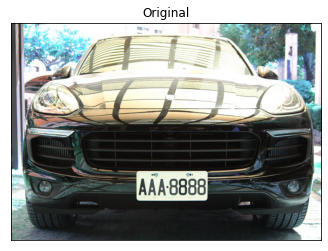

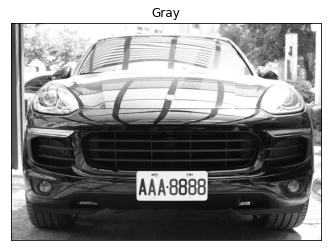

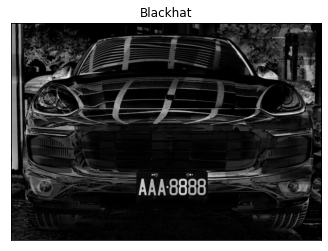

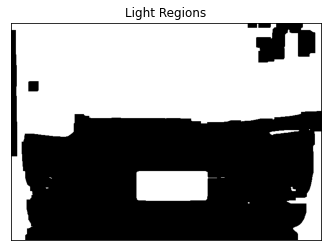

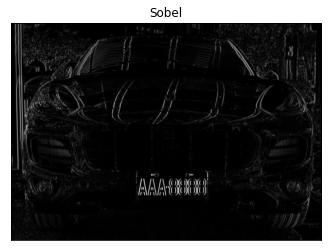

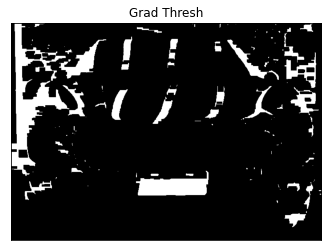

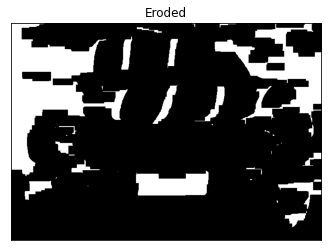

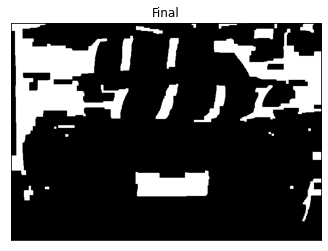

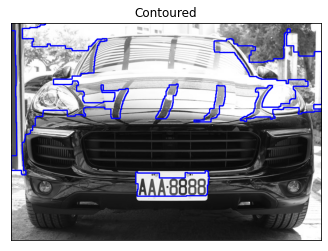

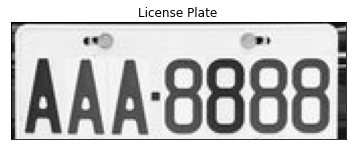

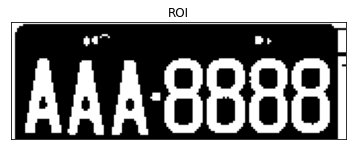

In [93]:
search1 = ImageSearchANPR()
path = "./license_plates/car5.jpg"
img1 = cv2.imread(path, cv2.IMREAD_COLOR)
(text1, _) = search1.find_ocr_and_contour(img1)
print(text1)